# Project 4: West Nile Virus Classification
---
    Chenyze | Elaine | Kenrick | Raphael
    
---
Project notebook organisation:<br>
[1 - Exploratory Data Analysis and Feature Engineering](./1_eda_and_feature_engineering.ipynb)<br>
**2 - Model Tuning and Insights** (current notebook)<br>
<br>
<br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-Data" data-toc-modified-id="Preparing-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing Data</a></span><ul class="toc-item"><li><span><a href="#Reading-pickle" data-toc-modified-id="Reading-pickle-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reading pickle</a></span></li><li><span><a href="#Cleaning-up-data" data-toc-modified-id="Cleaning-up-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cleaning up data</a></span></li></ul></li><li><span><a href="#Dictionaries-to-call-for-modelling" data-toc-modified-id="Dictionaries-to-call-for-modelling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dictionaries to call for modelling</a></span></li><li><span><a href="#RUNNING-MODEL-AND-PICKLING-IT" data-toc-modified-id="RUNNING-MODEL-AND-PICKLING-IT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>RUNNING MODEL AND PICKLING IT</a></span></li><li><span><a href="#Cost-Benefit-Analysis" data-toc-modified-id="Cost-Benefit-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cost-Benefit Analysis</a></span><ul class="toc-item"><li><span><a href="#Cost" data-toc-modified-id="Cost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Cost</a></span></li><li><span><a href="#Benefit" data-toc-modified-id="Benefit-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Benefit</a></span></li><li><span><a href="#Effectiveness-of-spraying-efforts-thus-far" data-toc-modified-id="Effectiveness-of-spraying-efforts-thus-far-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Effectiveness of spraying efforts thus far</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Conclusion-and-Recommendations" data-toc-modified-id="Conclusion-and-Recommendations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion and Recommendations</a></span></li></ul></div>

In [1]:
# importing essential libraries for data cleaning and EDA
import numpy as np
import pandas as pd

# for handling date time
import datetime as dt

# stats and other libraries
import scipy.stats as stats

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# for handling geographic data

# modeling libraries
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score


import xgboost as xgb
from xgboost import XGBClassifier

from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import string
import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE



sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline


## Preparing Data

### Reading pickle

In [2]:
df_processed = pd.read_pickle('./assets/processed.zip')
df_dict = df_processed.to_dict()

test = pd.read_csv('./assets/test.csv', parse_dates=['Date'])


### Cleaning up data

In [3]:
for i in df_dict.keys():
    df_dict[i]['train'] = df_dict[i]['train'].drop(columns = 'Species_UNSPECIFIED CULEX')
    df_dict[i]['test'] = df_dict[i]['test'].drop(columns = ['Species_UNSPECIFIED CULEX', 'WnvPresent'])

In [4]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}
X_all = {}
y_all = {}
test_all = {}

In [5]:
# For loop to populate dictionaries of X and Y training and test sets,

for i in df_dict.keys():
    X_train[i], X_test[i], y_train[i], y_test[i] = \
    train_test_split(df_dict[i]['train'].drop(columns = 'WnvPresent'), df_dict[i]['train']['WnvPresent'], \
                     test_size = 0.25, stratify = df_dict[i]['train']['WnvPresent'], random_state = 42)
    X_all[i] = df_dict[i]['train'].drop(columns = 'WnvPresent')
    y_all[i] = df_dict[i]['train']['WnvPresent']
    test_all[i] = df_dict[i]['test']



## Dictionaries to call for modelling

In [62]:
# Defining dictionary of pipeline transformers and classifiers

pipe_dict = {'ss' : ('ss', StandardScaler()),
             'lr' : ('lr', LogisticRegression()),
             'knn' : ('knn', KNeighborsClassifier()),
             'dt' : ('dt', DecisionTreeClassifier()),
             'rf' : ('rf', RandomForestClassifier()),
             'et' : ('et', ExtraTreesClassifier()),
             'xgc' : ('xgc', xgb.XGBClassifier(scale_pos_weight = 19, seed = 42)),
            }


# Defining dictionary of parameters for pipeline transformers

param_dict = {'lr_params' : {'lr__penalty' : ['l1', 'l2'],
                             'lr__solver' : ['liblinear'],
                             'lr__C' : np.logspace(-5, 0, 100),
                             'lr__class_weight' : ['balanced']
                            }, \
              'knn_params' : {'knn__n_neighbors' : [1, 3, 5, 7, 15],
                              'knn__weights':['uniform','distance'],
                              'knn__metric':['euclidean','manhattan']
                             }, \
              'dt_params' : {'dt__max_depth': [2, 3, 5, 7, 10],
                             'dt__min_samples_split': [5, 10, 15, 20],
                             'dt__min_samples_leaf': [2, 3, 4, 5, 6, 7],
                             'dt__class_weight' : ['balanced'],

                            }, \
              'rf_params' : {'rf__n_estimators': [10, 20, 50, 100, 150, 200],
                             'rf__max_depth': [5, 10, 15, 20, 25],
                             'rf__min_samples_leaf': [2, 5, 10],
                             'rf__class_weight' : ['balanced', 'balanced_subsample']
                            }, \
              'et_params' : {'et__n_estimators': [10, 20, 50, 100, 150, 200],
                             'et__max_depth': [2, 3, 4, 5, 10, 20],
                             'et__min_samples_leaf': [2, 5, 10],
                             'et__class_weight' : ['balanced', 'balanced_subsample'],
                            }, \
#               'xgc_params' : {'dt__max_depth': [2, 3, 5, 7, 10],
#                              'dt__min_samples_split': [5, 10, 15, 20],
#                              'dt__min_samples_leaf': [2, 3, 4, 5, 6, 7]
#                              }, \
#               'xgc_params' : {'xgc__eval_metric' : ['auc'],
#                               'xgc__objective' : ['binary:logistic'],
#                               'xgc__scale_pos_weight': [19],
#                               'xgc__subsample' : [0.3, 0.5, 0.7],
#                               'xgc__colsample_bytree' : [0.3, 0.5, 0.7],
#                               'xgc__learning_rate' : [0.05, 0.10],
#                               'xgc__max_depth' : [2, 3, 5],
#                               'xgc__n_estimators' : [500, 1000, 1500],
#                                   'xgc__reg_alpha' : [0, 1, 5],
#                                   'xgc__reg_lambda' : [1, 2, 3, 4, 5],
#                                   'xgc__gamma' : [0.01, 0.1, 0.25],
#                                  }, \

             }

param_no_tuning = {'lr_params' : {},\
                   'knn_params' : {},\
                   'dt_params' : {},\
                   'rf_params' : {},\
                   'et_params' : {},\
                   'xgc_params' : {},\
                   'lr_params' : {}
                  }

param_tuning_reg = {'lr_params' : {},\
                   'knn_params' : {},\
                   'dt_params' : {},\
                   'rf_params' : {},\
                   'et_params' : {},\
                   'xgc_params' : {},\
                   'lr_params' : {}
                  }



# Defining dictionary of more descriptive names for pipeline transformers and classifiers

pipe_dict_names = {'ss' : 'Standard Scaler',
                   'lr' : 'Logistic Regression',
                   'knn' : 'K Nearest Neighbors',
                   'dt' : 'Decision Tree',
                   'et' : 'Extra Trees',
                   'rf' : 'Random Forest',
                   'xgc' : 'XGBoost',
                  }


In [42]:
# Defining function to run pipeline model for each set of X stored in X_dict above and populate model_dict with model \
# parameters and results

def model_making(X_dict, scaler, classifier, model_dict, param_dict):
    for i in df_dict.keys():
        # Defining model_name to be used as key for model_dict
        model_name = '_'.join([classifier, str(i)])
        
        # Initialising empty dictionary (within the model_dict dictionary) to store instanced model parameters and results
        model_dict[model_name] = {}
        
        if scaler == None:
            model_dict[model_name]['name'] = ' '.join([pipe_dict_names[classifier], df_dict[i]['name']])
            model_dict[model_name]['pipe'] = Pipeline([pipe_dict[classifier]])
        else:
            model_dict[model_name]['name'] = ' '.join([pipe_dict_names[classifier], df_dict[i]['name'], pipe_dict_names[scaler]])
            model_dict[model_name]['pipe'] = Pipeline([pipe_dict[scaler], pipe_dict[classifier]])            
        
        
        model_dict[model_name]['params'] = param_dict[classifier + '_params'].copy()

        
        # Defining vectoriser parameter grid for model instance

        # Defining model for GridSearchCV using above pipeline and parameters
        model_dict[model_name]['model'] = GridSearchCV(model_dict[model_name]['pipe'], \
                                                       param_grid = model_dict[model_name]['params'],
                                                       cv = 3,
                                                       verbose = 1,
                                                       scoring = 'roc_auc',
                                                       n_jobs = 8)

        # Fitting model for GridSearchCV
        model_dict[model_name]['model'].fit(X_train[i], y_train[i])
        
        # Storing cross-validation scores and best parameters for model instance
        model_dict[model_name]['train_score'] = model_dict[model_name]['model'].best_score_ 
        model_dict[model_name]['best_params'] = model_dict[model_name]['model'].best_params_
        model_dict[model_name]['test_score'] = roc_auc_score(y_test[i], [prob[1] for prob in model_dict[model_name]['model'].best_estimator_.predict_proba(X_test[i])])
        model_dict[model_name]['confusion_matrix'] = pd.DataFrame(confusion_matrix(y_test[i],\
                                                                                   model_dict[model_name]['model'].
                                                                                   best_estimator_.predict(X_test[i])), \
                                                                  index = ['Actual WNV absent','Actual WNV present'],
                                                                  columns = ['predicted WNV absent', 'predicted WNV present'])
        # Storing predict_probability from best scoring model instance
        model_dict[model_name]['best_model'] = model_dict[model_name]['model'].best_estimator_.fit(X_all[i], y_all[i])
        model_dict[model_name]['train_pred_proba'] = [i[1] for i in model_dict[model_name]['best_model'].predict_proba(X_all[i])]
        model_dict[model_name]['train_pred_df'] = pd.DataFrame({'True_Values' : y_all[i],
                                                                'Pred_Probs' : model_dict[model_name]['train_pred_proba']})

        model_dict[model_name]['test_pred_proba'] = [i[1] for i in model_dict[model_name]['best_model'].predict_proba(test_all[i])]


            
        # Printing scores and best parameters for model instance
        print(model_dict[model_name]['name'], '\n')
        print(f'Score on Train Set:', model_dict[model_name]['train_score'])
        print(f'Best Parameters:', model_dict[model_name]['best_params'])
        print(f'Score on Test Set:', model_dict[model_name]['test_score'])
        print(model_dict[model_name]['confusion_matrix'], f'\n\n')
        

In [8]:
model_no_tuning = {}

In [9]:
model_making(df_dict, 'ss', 'lr', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Logistic Regression Rolling 10 days Standard Scaler 

Score on Train Set: 0.7787730769397748
Best Parameters: {}
Score on Test Set: 0.776672431160876
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2489                      0
Actual WNV present                   138                      0 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


Logistic Regression Rolling 14 days Standard Scaler 

Score on Train Set: 0.7763094380290411
Best Parameters: {}
Score on Test Set: 0.7765501540109817
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2489                      0
Actual WNV present                   138                      0 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


Logistic Regression Rolling 18 days Standard Scaler 

Score on Train Set: 0.7822119253993277
Best Parameters: {}
Score on Test Set: 0.7831036269731748
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2489                      0
Actual WNV present                   138                      0 




In [10]:
model_making(df_dict, 'ss', 'knn', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s finished


K Nearest Neighbors Rolling 10 days Standard Scaler 

Score on Train Set: 0.6539481702213693
Best Parameters: {}
Score on Test Set: 0.6910449455866682
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2469                     20
Actual WNV present                   131                      7 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s finished


KeyboardInterrupt: 

In [13]:
model_making(df_dict, None, 'dt', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


Decision Tree Rolling 10 days 

Score on Train Set: 0.6086546035539488
Best Parameters: {}
Score on Test Set: 0.5978129858333188
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2400                     89
Actual WNV present                   121                     17 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Decision Tree Rolling 14 days 

Score on Train Set: 0.6168031922466012
Best Parameters: {}
Score on Test Set: 0.6131587681450557
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2410                     79
Actual WNV present                   116                     22 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


Decision Tree Rolling 18 days 

Score on Train Set: 0.6144195984125821
Best Parameters: {}
Score on Test Set: 0.6084743887598186
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2408                     81
Actual WNV present                   118                     20 




In [14]:
model_making(df_dict, None, 'et', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Extra Trees Rolling 10 days 

Score on Train Set: 0.7004673520847958
Best Parameters: {}
Score on Test Set: 0.6608439452431277
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2452                     37
Actual WNV present                   127                     11 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Extra Trees Rolling 14 days 

Score on Train Set: 0.6940014722920368
Best Parameters: {}
Score on Test Set: 0.6862601242568751
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2451                     38
Actual WNV present                   127                     11 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Extra Trees Rolling 18 days 

Score on Train Set: 0.6900682748007114
Best Parameters: {}
Score on Test Set: 0.6784402093850624
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2455                     34
Actual WNV present                   124                     14 




In [15]:
model_making(df_dict, None, 'rf', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Random Forest Rolling 10 days 

Score on Train Set: 0.7166459317572165
Best Parameters: {}
Score on Test Set: 0.7138074193116379
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2455                     34
Actual WNV present                   124                     14 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Random Forest Rolling 14 days 

Score on Train Set: 0.712737829950049
Best Parameters: {}
Score on Test Set: 0.7173272544121672
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2451                     38
Actual WNV present                   124                     14 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Random Forest Rolling 18 days 

Score on Train Set: 0.7303666981518532
Best Parameters: {}
Score on Test Set: 0.7029218416103318
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2447                     42
Actual WNV present                   123                     15 




In [16]:
model_making(df_dict, None, 'xgc', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s finished


XGBoost Rolling 10 days 

Score on Train Set: 0.8365894074163807
Best Parameters: {}
Score on Test Set: 0.8345168014626676
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1837                    652
Actual WNV present                    33                    105 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s finished


XGBoost Rolling 14 days 

Score on Train Set: 0.8355804078017162
Best Parameters: {}
Score on Test Set: 0.8331440948870683
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1858                    631
Actual WNV present                    35                    103 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s finished


XGBoost Rolling 18 days 

Score on Train Set: 0.8341216501905979
Best Parameters: {}
Score on Test Set: 0.8340771859951904
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1827                    662
Actual WNV present                    33                    105 




In [17]:
predict = model_no_tuning['xgc_1']['test_pred_proba']

output = pd.DataFrame(zip(test['Id'], predict), columns = ['Id', 'WnvPresent'])

output.to_csv('./datasets/YOLO_20191107_2123_xgc_00_10_sum_precip-sunlight_w-clusters_no_tuning.csv', index = False)

## RUNNING MODEL AND PICKLING IT

In [38]:
#Initialising empty dictionary to store model data

model_dict = {}

#model_dict_reg = {}

In [64]:


model_making(df_dict, 'ss', 'lr', model_dict, param_dict)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 541 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:  1.0min finished


Logistic Regression Rolling 10 days Standard Scaler 

Score on Train Set: 0.7898941417726049
Best Parameters: {'lr__C': 0.8902150854450392, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Score on Test Set: 0.7876686405692293
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1739                    750
Actual WNV present                    35                    103 


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 536 tasks      | elapsed:   26.5s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:   58.8s finished


Logistic Regression Rolling 14 days Standard Scaler 

Score on Train Set: 0.7853260612228314
Best Parameters: {'lr__C': 0.6280291441834247, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Score on Test Set: 0.787619147437129
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1714                    775
Actual WNV present                    36                    102 


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 535 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:   55.9s finished


Logistic Regression Rolling 18 days Standard Scaler 

Score on Train Set: 0.7896449641476803
Best Parameters: {'lr__C': 0.7924828983539169, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Score on Test Set: 0.7927023832398786
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1751                    738
Actual WNV present                    38                    100 




In [63]:
model_making(df_dict, None, 'dt', model_dict, param_dict)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:    1.9s finished


Decision Tree Rolling 10 days 

Score on Train Set: 0.7923319471846698
Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
Score on Test Set: 0.7953488101268771
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1641                    848
Actual WNV present                    21                    117 


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:    1.9s finished


Decision Tree Rolling 14 days 

Score on Train Set: 0.7727286475710452
Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
Score on Test Set: 0.7935539562480712
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1663                    826
Actual WNV present                    24                    114 


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:    1.8s finished


Decision Tree Rolling 18 days 

Score on Train Set: 0.772631947711808
Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 6, 'dt__min_samples_split': 10}
Score on Test Set: 0.7954012146196889
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1584                    905
Actual WNV present                    24                    114 




In [60]:
model_making(df_dict, None, 'et', model_dict, param_dict)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 422 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 648 out of 648 | elapsed:   26.1s finished


Extra Trees Rolling 10 days 

Score on Train Set: 0.8362646889802677
Best Parameters: {'et__class_weight': 'balanced', 'et__max_depth': 20, 'et__min_samples_leaf': 5, 'et__n_estimators': 150}
Score on Test Set: 0.8305151361643404
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1959                    530
Actual WNV present                    45                     93 


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 370 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 620 tasks      | elapsed:   24.8s
[Parallel(n_jobs=8)]: Done 648 out of 648 | elapsed:   27.1s finished


Extra Trees Rolling 14 days 

Score on Train Set: 0.8392848082869544
Best Parameters: {'et__class_weight': 'balanced', 'et__max_depth': 20, 'et__min_samples_leaf': 5, 'et__n_estimators': 100}
Score on Test Set: 0.8329868814086328
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1988                    501
Actual WNV present                    50                     88 


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 404 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 648 out of 648 | elapsed:   27.2s finished


Extra Trees Rolling 18 days 

Score on Train Set: 0.837679439584434
Best Parameters: {'et__class_weight': 'balanced_subsample', 'et__max_depth': 20, 'et__min_samples_leaf': 5, 'et__n_estimators': 150}
Score on Test Set: 0.83314700624778
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1982                    507
Actual WNV present                    49                     89 




In [59]:
model_making(df_dict, None, 'rf', model_dict, param_dict)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 324 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:   31.1s finished


Random Forest Rolling 10 days 

Score on Train Set: 0.8434778914612783
Best Parameters: {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 20}
Score on Test Set: 0.8224623124355861
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2065                    424
Actual WNV present                    55                     83 


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 326 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:   32.0s finished


Random Forest Rolling 14 days 

Score on Train Set: 0.8421226568707366
Best Parameters: {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 100}
Score on Test Set: 0.8313346842047036
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1978                    511
Actual WNV present                    45                     93 


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 152 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 380 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:   31.7s finished


Random Forest Rolling 18 days 

Score on Train Set: 0.8415179658268298
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 150}
Score on Test Set: 0.8294452111027653
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1976                    513
Actual WNV present                    45                     93 




In [65]:
model_dict.keys()

dict_keys(['lr_1', 'lr_2', 'lr_3', 'dt_1', 'dt_2', 'dt_3', 'et_1', 'et_2', 'et_3', 'rf_1', 'rf_2', 'rf_3'])

In [66]:
model_df = pd.DataFrame(model_dict)

In [67]:
model_df.to_pickle('./model_dict_20191108_0713hrs.zip')

In [ ]:
# Functions to plot prediction probability and ROC AUC curve

# Defining function to count true positive rate

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Defining function to count false positive rate
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# Defining function to plot prediction probability and ROC AUC curve for selected models
def subplot_prob_dist(model_dict, list_of_models):
    nrows = int(np.ceil(len(list_of_models)))
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (15, nrows * 5))
    plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    ax = ax.flatten()

    thresholds = np.linspace(0, 1, 200)

    for i, model_name in enumerate(list_of_models):
        pred_df = model_dict[model_name]['pred_df']
        model_desc = model_dict[model_name]['name']
        
        roc_auc = roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])
        
        try:
            ax[(i * 2)].hist(pred_df[pred_df['true_values'] == 0]['pred_probs'], bins = 25, color = 'b', \
                             alpha = 0.6, label = 'Outcome = r/personalfinance')
            ax[(i * 2)].hist(pred_df[pred_df['true_values'] == 1]['pred_probs'], bins = 25, color = 'y', \
                                 alpha = 0.6, label = 'Outcome = r/investing')
            ax[(i * 2)].set_title(f'{model_desc} \n Distribution of P(Outcome = r/investing)')
            ax[(i * 2)].set_ylabel('Frequency')
            ax[(i * 2)].set_xlabel('Predicted Probability that Outcome = r/investing')
            ax[(i * 2)].legend(loc = 'upper center')
        except:
            pass
        
        
        try:
            tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
            fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
 
            ax[(i * 2 + 1)].plot(fpr_values, tpr_values, label = 'ROC Curve', color = 'c')
            ax[(i * 2 + 1)].plot((0, 0), (0, tpr_values[len(tpr_values) - 1]), color = 'c')
            ax[(i * 2 + 1)].plot((fpr_values[0], 1), (1 , 1), color = 'c')
            ax[(i * 2 + 1)].plot(thresholds, thresholds, label = 'baseline', linestyle = '--', color = 'y')
            ax[(i * 2 + 1)].set_title(f'{model_desc}  \n ROC AUC = {roc_auc:2f}')
            ax[(i * 2 + 1)].set_ylabel('Sensitivity')
            ax[(i * 2 + 1)].set_xlabel('1 - Specificity')
            ax[(i * 2 + 1)].legend(loc = 'lower right')
            
            
        except:
            pass




## Cost-Benefit Analysis

### Cost
The Chicago Department of Public Health (CDPH) conducts mosquito spraying as part of their measure to reduce the occurrence of WNV. The spraying is conducted from dusk to around midnight from ultra low volumn (ULV) sprayer trucks, using the chemical Zenivex™ E4 ([City of Chicago, 2019](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2019/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html)). This is a 4% solution of etofenprox, sprayed at 4.5 - 9 ounces per minute, at a vehicle speed of 10 - 15 mph ([Central Massachussettes Mosquito Control Project](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox)). Assuming each truck has an area of effect of about 3 m to each side of the truck, the overall spray area is approximately **0.6 km<sup>2</sup>** per truck.

The cost of Zenivex E4 is about \$80 USD per gallon ([North Dakota Department of Health, 2013](http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf)). Given the current rate of spraying and assuming a total spray duration of 5 hours, the cost of pesticides for <i>each sprayer truck</i> is <b>\\$843.76 - \$1687.50 USD</b>. 

Given that the total area of Chicago is 606.1 km<sup>2</sup>, it would take about 1000 trucks at the same time to cover the entire area. 

### Benefit
Benefits from mosquito spraying would include increased quality of life from fewer people falling sick and dying, increased workplace productivity from fewer people falling ill and going on medical leave, as well as savings in hospital expenses from treating WNV patients. Of these, only the latter two are measurable.

About 1 in 5 people infected with WNV develop West Nile fever with other symptoms such as headache, body aches, joint pains, vomiting, etc. Recovery from West Nile fever takes from a few days to several weeks, and prolonged fatigue is common ([Peterson, 2019](https://www.uptodate.com/contents/west-nile-virus-infection-beyond-the-basics)). 

About 1 in 150 people infected develop severe neuroinvasive diseases such as encephalitis or meningitis, in which the virus travels through the blood and infects the brain and spinal cord. Recovery is prolonged and less than 40% of patients with the severe diseases recover after one year ([Peterson, 2019](https://www.uptodate.com/contents/west-nile-virus-infection-beyond-the-basics)).

Given that the median household income in Chicago was \\$55,295 (as of 2017; [Data USA](https://datausa.io/profile/geo/chicago-il/)), one can estimate the amount of losses the city will face from an incapacitated workforce. In 2017, there were 90 WNV cases, including 8 deaths ([CBS Chicago, 2019](https://chicago.cbslocal.com/2018/08/29/west-nile-virus-death-reported-in-illinois/)). This means that approximately 18 people developed West Nile fever. Assuming all were working adults and each took two weeks off work to recover, this would have resulted in a total income loss of \\$19,353. On average, each WNV patient spends approximately \\$25,000 in the hospital. Therefore the total monetary loss caused by WNV in 2017 is approximately \\$488,176.

### Effectiveness of spraying efforts thus far
Based on the exploratory data analysis conducted earlier, there was a lack of evidence to support the claim that mosquito spraying had any effect on reducing the number of mosquitos. It was also revealed during earlier EDA that spraying was only done in 2011 and 2013, and mostly in September. As this is near the end of summer, breeding conditions were already becoming less favourable for mosquitos, therefore it would be difficult to discern the effects of spraying from the natural decline in mosquito populations. Further examinations of spraying efforts in 2013 August also did not reveal any noticable decrease in WNV occurrences. 

### Conclusions
From the graph below, it can be seen that the money saved from reducing WNV cases would at most fund about 300 - 500 sprays. However, as the current datasets do not substantially point to a significant impact from spraying, more evidence (from a better designed spraying regime) are needed for a more concrete recommendation. For example, spraying efforts could be concentrated at the beginning of August so that there would be enough time to observe if mosquito numbers decline, in the relative absence of other confounding factors (such as temperature). 

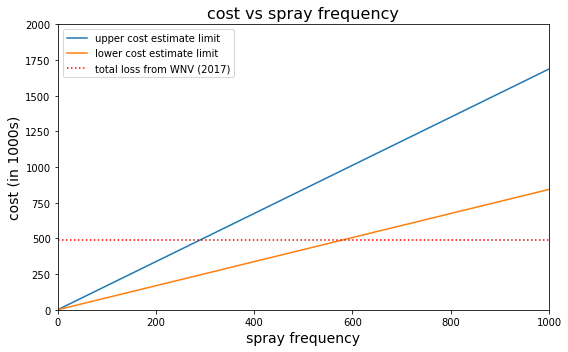

In [19]:
# max/optimal level of pesticide coverage
# spraying frequency of twice a month (to cover the mosquito life cycle)
# 1000 trucks at a time (to cover the whole Chicago)
max_frequency = 25 * 1000

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, max_frequency),
         np.arange(1, max_frequency) * 1687.5/1000, label = 'upper cost estimate limit')
plt.plot(np.arange(1, max_frequency),
         np.arange(1, max_frequency) * 843.75/1000, label = 'lower cost estimate limit')
plt.axhline(488_176/1000, color='r', linestyle=':', label = 'total loss from WNV (2017)')
plt.title('cost vs spray frequency', fontsize=16)
plt.xlabel('spray frequency', fontsize=14)
plt.ylabel('cost (in 1000s)', fontsize=14)
plt.ylim(0,2000)
plt.xlim(0,1000)
plt.legend()
plt.tight_layout()
plt.savefig('cost_benefit')

## Conclusion and Recommendations

Using XGBoost (our best performing model), we achieved an ROC_AUC of **0.839** and the following confusion matrix:

||predicted WNV absent|predicted WNV present|
|---|---|---|
|actual WNV absent|2045|444|
|actual WNV present|54|84|

Using the model, we found that WNV is more prevalent under certain conditions. **Week of year** was the top predictor by far for our model, followed by day of year, 10-days rolling sum of daylight hours, <i>Culex restuans</i>, and 10-days rolling mean of average temperature. This means that WNV is most likely to occur during certain weeks of the year (in August, as shown in the figure above), and therefore spray efforts should be concentrated during this period. Location was not a strong predictor in our model, suggesting that WNV clusters may be transient, occurring where best conditions emerge. 

After conducting a cost-benefit analysis, we found that the money saved from reducing WNV cases would at most fund about 300 - 500 sprays. However, as the current datasets do not substantially point to a significant impact from spraying, more evidence (from a better designed spraying regime) are needed for a more concrete recommendation. For example, spraying efforts could be concentrated at the beginning of August so that there would be enough time to observe if mosquito numbers decline, in the relative absence of other confounding factors (such as temperature). 